### 9.4 주파수 영역 필터링

원형 필터 : 저주파만 남김 = 블러링 효과

원형이 제외된 필터 : 고주파만 남김 = 엣지만 추출됨

In [2]:
# 9.4.1 주파수 영역 필터링
import numpy as np, cv2
from Common.dft2d import dft, idft, calc_spectrum, fftshift

def FFT(image, mode=2):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft = fftshift(dft)
    spectrum = calc_spectrum(dft)
    return dft, spectrum

def IFFT(dft, shape, mode=2):
    dft = fftshift(dft)
    img = cv2.idft(dft, flags=cv2.DFT_SCALE)[:,:,0]
    img = img[:shape[0], :shape[1]]
    return cv2.convertScaleAbs(img)

image = cv2.imread("images_09/test.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 오류")

cy, cx = np.divmod(image.shape, 2)[0]
mode = 3

dft, spectrum = FFT(image, mode)
lowpass = np.zeros(dft.shape, np.float32)
highpass = np.ones(dft.shape, np.float32)
cv2.circle(lowpass, (cx, cy), 30, (1, 1), -1)
cv2.circle(highpass, (cx, cy), 30, (0, 0), -1)

lowpassed_dft = dft * lowpass
highpassed_dft = dft * highpass
lowpassed_img = IFFT(lowpassed_dft, image.shape, mode)
highpassed_img = IFFT(highpassed_dft, image.shape, mode)

cv2.imshow("image", image)
cv2.imshow("lowpassed_img", lowpassed_img)
cv2.imshow("highpassed_img", highpassed_img)
cv2.imshow("spectrum", spectrum)
cv2.imshow("calc_spectrum(lowpassed_dft)", calc_spectrum(lowpassed_dft))
cv2.imshow("calc_spectrum(highpassed_dft)", calc_spectrum(highpassed_dft))
cv2.waitKey(0)

-1

ValueError: Argument Z must be 2-dimensional.

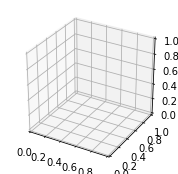

In [2]:
# 9.4.2 주파수 영역 필터링2
import numpy as np, cv2
from Common.dft2d import calc_spectrum, FFT, IFFT
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_gaussianFilter(shape, R):
    u = np.array(shape)//2
    y = np.arange(-u[0], u[0], 1)
    x = np.arange(-u[1], u[1], 1)
    x, y = np.meshgrid(x, y)
    filter = np.exp(-(x**2 + y**2) / (2*R**2))
    return x, y, filter if len(shape) < 3 else cv2.merge([filter, filter])

def get_butterworthFilter(shape, R, n):
    u = np.array(shape)//2
    y = np.arange(-u[0], u[0], 1)
    x = np.arange(-u[1], u[1], 1)
    x, y = np.meshgrid(x, y)
    dist = np.sqrt(x**2 + y**2)
    filter = 1 / (1 + np.power(dist / R, 2 * n))
    return x, y, filter if len(shape) < 3 else cv2.merge([filter, filter])

image = cv2.imread("images_09/test.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 오류")

mode = 2
dft, spectrum = FFT(image, mode)
x1, y1, gauss_filter = get_gaussianFilter(dft.shape, 30)
x2, y2, butter_filter = get_butterworthFilter(dft.shape, 30, 10)

filterd_dft1 = dft * gauss_filter
filterd_dft2 = dft * butter_filter
gauss_img = IFFT(filterd_dft1, image.shape, mode)
butter_img = IFFT(filterd_dft2, image.shape, mode)
spectrum1 = calc_spectrum(filterd_dft1)
spectrum2 = calc_spectrum(filterd_dft2)

if mode == 3:
    gauss_filter, butter_filter, = gauss_filter[:, :, 0], butter_filter[:, :, 0]

plt.figure(figsize=(10, 10))
ax1 = plt.subplot(332, projection='3d')
ax1.plot_surface(x1, y1, gauss_filter, cmap='RdPu')
plt.title('gauss_filter')

ax2 = plt.subplot(333, projection='3d')
ax2.plot_surface(x2, y2, butter_filter, cmap='RdPu')
plt.title('butter_filter')

titles = ['image', 'gauss_img', 'butter_img', 'spectrum', 'spectrum1', 'spectrum2']
images = [image, gauss_img, butter_img, spectrum, spectrum1, spectrum2]
plt.gray()

for i, t in enumerate(titles):
    plt.subplot(3, 3, i+4)
    plt.imshow(images[i]), plt.title(t)
plt.tight_layout()
plt.imshow()


두 가지 신호가 겹치는 경우 발생하는 모아레 현상을 제거

In [3]:
# 9.4.3 모아레 제거
import numpy as np, cv2
from Common.dft2d import calc_spectrum, FFT, IFFT

def onRemoveMoire(val):
    radius = cv2.getTrackbarPos('radius', title)
    th = cv2.getTrackbarPos('threshold', title)

    mask = cv2.threshold(spectrum_img, th, 255, cv2.THRESH_BINARY_INV)[1]
    y, x = np.divmod(mask.shape, 2)[0]
    cv2.circle(mask, (x, y), radius, 255, 1)

    if dft.ndim<3:
        remv_dft = np.zeros(dft.shape, np.complex)
        remv_dft.imag = cv2.copyTo(dft.imag, mask=mask)
        remv_dft.real = cv2.copyTo(dft.real, mask=mask)
    else:
        remv_dft = cv2.copyTo(dft, mask=mask)
    
    result[:, image.shape[1]:] = IFFT(remv_dft, image.shape, mode)
    cv2.imshow(title, calc_spectrum(remv_dft))
    cv2.imshow('result', result)

image = cv2.imread("images_09/test.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 오류")

mode = 3
result = cv2.repeat(image, 1, 2)
dft, spectrum_img = FFT(image, mode)

title = 'removed moire'
cv2.imshow('result', result)
cv2.imshow(title, spectrum_img)
cv2.createTrackbar('radius', title, 10, 255, onRemoveMoire)
cv2.createTrackbar('threshold', title, 120, 255, onRemoveMoire)
cv2.waitKey(0)


error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:868: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


-1

이산 코사인 변환 : 허수부를 없앨 수 있는 방법을 찾음

허수부가 매우 작기 때문에 무시해도 상관 없음 -> 데이터가 없어지기 때문에 압축할 수 있음 -> 연산량과 저장량이 줄어듦

-> jpeg, mpeg 등에서 사용함

-> 이런게 있다 정도만 알면 됨

In [4]:
# 9.5.1 이산 코사인 변환
import numpy as np, cv2, math
import scipy.fftpack as sf

def cos(n, k, N):
    return math.cos((n+1/2) * math.pi * k/N)

def C(k, N):
    return math.sqrt(1/N) if k==0 else math.sqrt(2/N)

def dct(g):
    N = len(g)
    f = [C(k, N) * sum(g[n] * cos(n, k, N) for n in range(N)) for k in range(N)]
    return np.array(f, np.float32)

def idct(f):
    N = len(f)
    g = [sum(C(k, N) * f[k] * cos(n, k, N) for k in range(N)) for n in range(N)]
    return np.array(g)

def dct2(image):
    tmp = [dct(row) for row in image]
    dst = [dct(row) for row in np.transpose(tmp)]
    return np.transpose(dst)

def idct2(iamge):
    tmp = [idct(row) for row in image]
    dst = [idct(row) for row in np.transpose(tmp)]
    return np.transpose(dst)

def scipy_dct2(a):
    tmp = sf.dct(a, axis=0, norm='ortho')
    tmp = sf.dct(tmp, axis=1, norm='ortho')

def scipy_idct2(a):
    tmp = sf.idct(a, axis=0, norm='ortho')
    return sf.idct(tmp, axis=1, norm='ortho')

block = np.zeros((3,5), np.uint8)
cv2.randn(block, 128, 50)

dct4 = cv2.dct(block.astype('float32'))

idct4 = cv2.dct(dct4, flags=cv2.DCT_INVERSE)

print('block =', block)
print('cv dct =\n', dct4)
print('cv idct =\n', cv2.convertScaleAbs(idct4))


block = [[128 136  93 107 190]
 [114  96 143 154  71]
 [166 126 193  30  33]]
cv dct =
 [[ 459.594      53.969677  -22.501207    1.200143   44.138367]
 [  33.520145 -100.550446   75.75286   -22.76198   -59.75286 ]
 [   8.398418   32.89206    38.765007  -61.456863   32.826427]]
cv idct =
 [[128 136  93 107 190]
 [114  96 143 154  71]
 [166 126 193  30  33]]


In [3]:
# 9.5.2 DCT를 이용한 주파수 영역 필터링
import numpy as np, cv2
from Common.dct import dct2, idct2, scipy_dct2, scipy_idct2

def dct2_mode(block, mode):
    if mode == 1: return dct2(block)
    elif mode == 2: return scipy_dct2(block)
    elif mode == 3: return cv2.dct(block.astype('float32'))

def idct2_mode(block, mode):
    if mode == 1: return idct2(block)
    elif mode == 2: return scipy_idct2(block)
    ########## error
    elif mode == 3: return cv2.dct(block, flags=cv2.DCT_INVERSE)

def dct_filtering(img, filter, M, N):
    dst = np.empty(img.shape, np.float32)
    for i in range(0, img.shape[0], M):
        for j in range(0, img.shape[1], N):
            block = img[i:i+M, j:j+N]
            new_block = dct2_mode(block, mode)
            new_block = new_block * filter
            dst[i:i+M, j:j+N] = idct2_mode(new_block, mode)
    return cv2.convertScaleAbs(dst)

image = cv2.imread("images_09/test.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 오류")

mode = 3
M, N = 8, 8

filters = [np.zeros((M, N), np.float32) for i in range(5)]
titles = ['DC Pass', 'High Pass', 'Low Pass', 'Vertiacl Pass', 'Horizental Pass']

filters[0][0, 0] = 1
filters[1][:], filters[2][0, 0] = 1, 0
filters[2][:M//2, :N//2] = 1
filters[3][0, 1:] = 1
filters[4][1:, 0] = 1

for filter, title in zip(filters, titles):
    dst = dct_filtering(image, filters, M, N)
    cv2.imshow(title, dst)

cv2.imshow('image', image)
cv2.waitKey(0)




error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\core\src\dxt.cpp:4417: error: (-215:Assertion failed) type == CV_32FC1 || type == CV_64FC1 in function 'cv::dct'
